In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
filename='indian_pines_all'
df = pd.read_csv(f'{filename}.csv')
print(df.columns)
df.head().append(df.tail())

Index(['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7', 'band8',
       'band9', 'band10',
       ...
       'band192', 'band193', 'band194', 'band195', 'band196', 'band197',
       'band198', 'band199', 'band200', 'class'],
      dtype='object', length=201)


,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band192,band193,band194,band195,band196,band197,band198,band199,band200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3
21020,2561,3987,4011,4023,4201,4377,4418,4248,4180,3838,...,1013,1012,1018,1015,1011,1001,1000,1009,1008,0
21021,2726,4104,4024,3880,4210,4377,4413,4174,4229,3900,...,1012,1014,1012,1024,998,1010,1006,1000,1000,0
21022,3153,3864,4282,3889,4310,4372,4375,4208,4096,3878,...,1016,1015,1016,1021,1008,1019,1003,1008,1000,0
21023,3155,4104,4106,4027,4139,4318,4413,4174,4140,3933,...,1005,1011,1008,1012,1014,1007,1011,1005,1003,0
21024,3323,3860,4197,3952,4148,4279,4375,4225,3988,3866,...,1018,1014,1007,1015,1002,1010,1007,1004,1000,0


In [3]:
names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees',
         'Grass-pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
         'Soybean-clean', 'Wheat', 'Woods', 'Buildings Grass Trees Drives', 'Stone Steel Towers']

## 真实标签

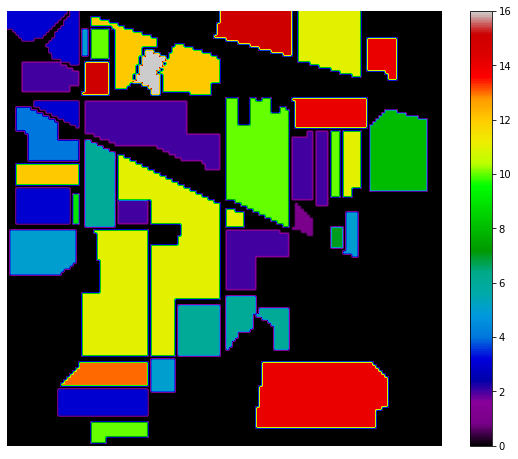

In [147]:
# 真实数据
y = pd.read_csv("df_indian_pines_gt.csv")

plt.figure(figsize=(10, 8))
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('./results/IP_cmap.png')
plt.show()

In [149]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int64)

In [150]:
len(np.unique(y))

17

# 1. 过滤式特征选择

## 1.1 相关系数法

In [4]:
# def corr_matrix(data, method='pearson'):
#     """
#     计算数据各特征之间的相关系数
#     ----
#     data:DataFrame
#     """

#     corr_matrix = data.corr(method=method) # 'pearson', 'spearman', 'kendall'

#     f, ax = plt.subplots(figsize=(16,8), dpi=300)

#     sns.heatmap(corr_matrix,
#                 annot=True, 
#                 fmt='.2f', 
#                 linewidth=0.4,
#                 annot_kws={'size': 10,}, 
#                 cmap='coolwarm', 
#                 ax=ax)
    
#     ax.set_title('$Pearson\ Correlation\ of\ HSI\ Data$', size=20)
    
# #     return corr_matrix
# #     plt.xticks(fontsize=10)
# #     plt.yticks(fontsize=10)
# #     plt.show()

# # # 200维度过多，绘图费时
# # corr_matrix = corr_matrix(df, method='pearson')

- API:https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest

`sklearn.feature_selection.SelectKBest(score_func=<function f_classif>, *, k=10)`

- 功能：SelecKBest 选择K个最好的特征，返回选择特征后的数据
- 参数score_func：计算评估特征是否好的函数，该函数输入特征矩阵和目标向量；
- 参数k：选择的特征个数；
- 返回值：数组（评分，P值），第i项为第i个特征的评分和P值。在此定义为计算相关系数。

---
- API:https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

`scipy.stats.pearsonr(x, y)`
- 输入：特征矩阵和目标向量
- 返回：(r, p-value)，皮尔逊相关系数和p-value

In [115]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr, spearmanr, kendalltau

def calculate_corr(df, method_func=pearsonr): # pearsonr
    """
    计算相关系数（皮尔逊、斯皮尔曼、肯达尔）
    ----
    df:DataFrame
    method_dunc:scipy.stats functions
    """
    # 计算列数
    n_cols = int(len(df.columns))
    # 相关系数矩阵，shape为 n_cols * n_cols，并初始化为0
    corr_matrix = [[0] * n_cols] * n_cols
    pvalue_matrix = [[0] * n_cols] * n_cols
    
    for i, out_col_idx in enumerate(np.arange(0, n_cols, 1)):
        for inn_col_idx in np.arange(i, n_cols, 1):
            # 计算相关系数和pvalue
            r, p = method_func(df.iloc[:, out_col_idx].values, df.iloc[:, inn_col_idx].values)
            corr_matrix[out_col_idx][inn_col_idx] = r
            pvalue_matrix[out_col_idx][inn_col_idx] = p
        
    return corr_matrix, pvalue_matrix

In [116]:
n_cols= 10
[[0] * n_cols] * n_cols

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [117]:
corr_matrix, pvalue_matrix = calculate_corr(df)

In [118]:
np.array(corr_matrix)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [119]:
np.unique(np.array(corr_matrix))

array([1., 1., 1., 1., 1., 1.])

## 1.2 方差选择法

- API：https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold

`sklearn.feature_selection.VarianceThreshold(threshold=0.0)`

- 功能：删除所有低方差特征
- threshold:float, default=0,方差的阈值
- 返回值：特征选择后的数据

In [140]:
from sklearn.feature_selection import VarianceThreshold

fs_vt = VarianceThreshold(threshold = 200000).fit_transform(df.iloc[:, :-1])
fs_vt

array([[5213, 5106, 5053, ..., 3784, 3642, 3271],
       [5352, 5353, 5347, ..., 4067, 3931, 2736],
       [5438, 5427, 5383, ..., 4145, 4011, 2804],
       ...,
       [4375, 4208, 4096, ..., 4766, 4599, 4010],
       [4413, 4174, 4140, ..., 4532, 4364, 3806],
       [4375, 4225, 3988, ..., 4647, 4486, 3899]], dtype=int64)

In [141]:
fs_vt.shape

(21025, 65)

## 1.3 卡方检验
- API：https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2

`sklearn.feature_selection.chi2(X, y)`
- 功能：计算每个非负要素与类之间的卡方统计量。选择最好的K个特征
- X
- y
- 返回：每个特征的Chi2统计信息以及P-Value

In [142]:
# 全局变量，选择最佳的特征数量
K_BEST = 50

In [145]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

fs_chi2 = SelectKBest(chi2, k= K_BEST).fit_transform(df.iloc[:, :-1], df.iloc[:, -1])
fs_chi2

array([[4750, 4816, 4769, ..., 2204, 2100, 2146],
       [5065, 5141, 5100, ..., 2303, 2195, 2228],
       [5132, 5227, 5172, ..., 2352, 2215, 2265],
       ...,
       [3878, 3890, 3683, ..., 1521, 1494, 1544],
       [3933, 3799, 3627, ..., 1490, 1466, 1510],
       [3866, 3811, 3639, ..., 1505, 1484, 1517]], dtype=int64)

In [146]:
fs_chi2.shape

(21025, 50)

# 2. 包裹式特征选择（200维太高，组合爆炸）
# idea:使用PCA先降维

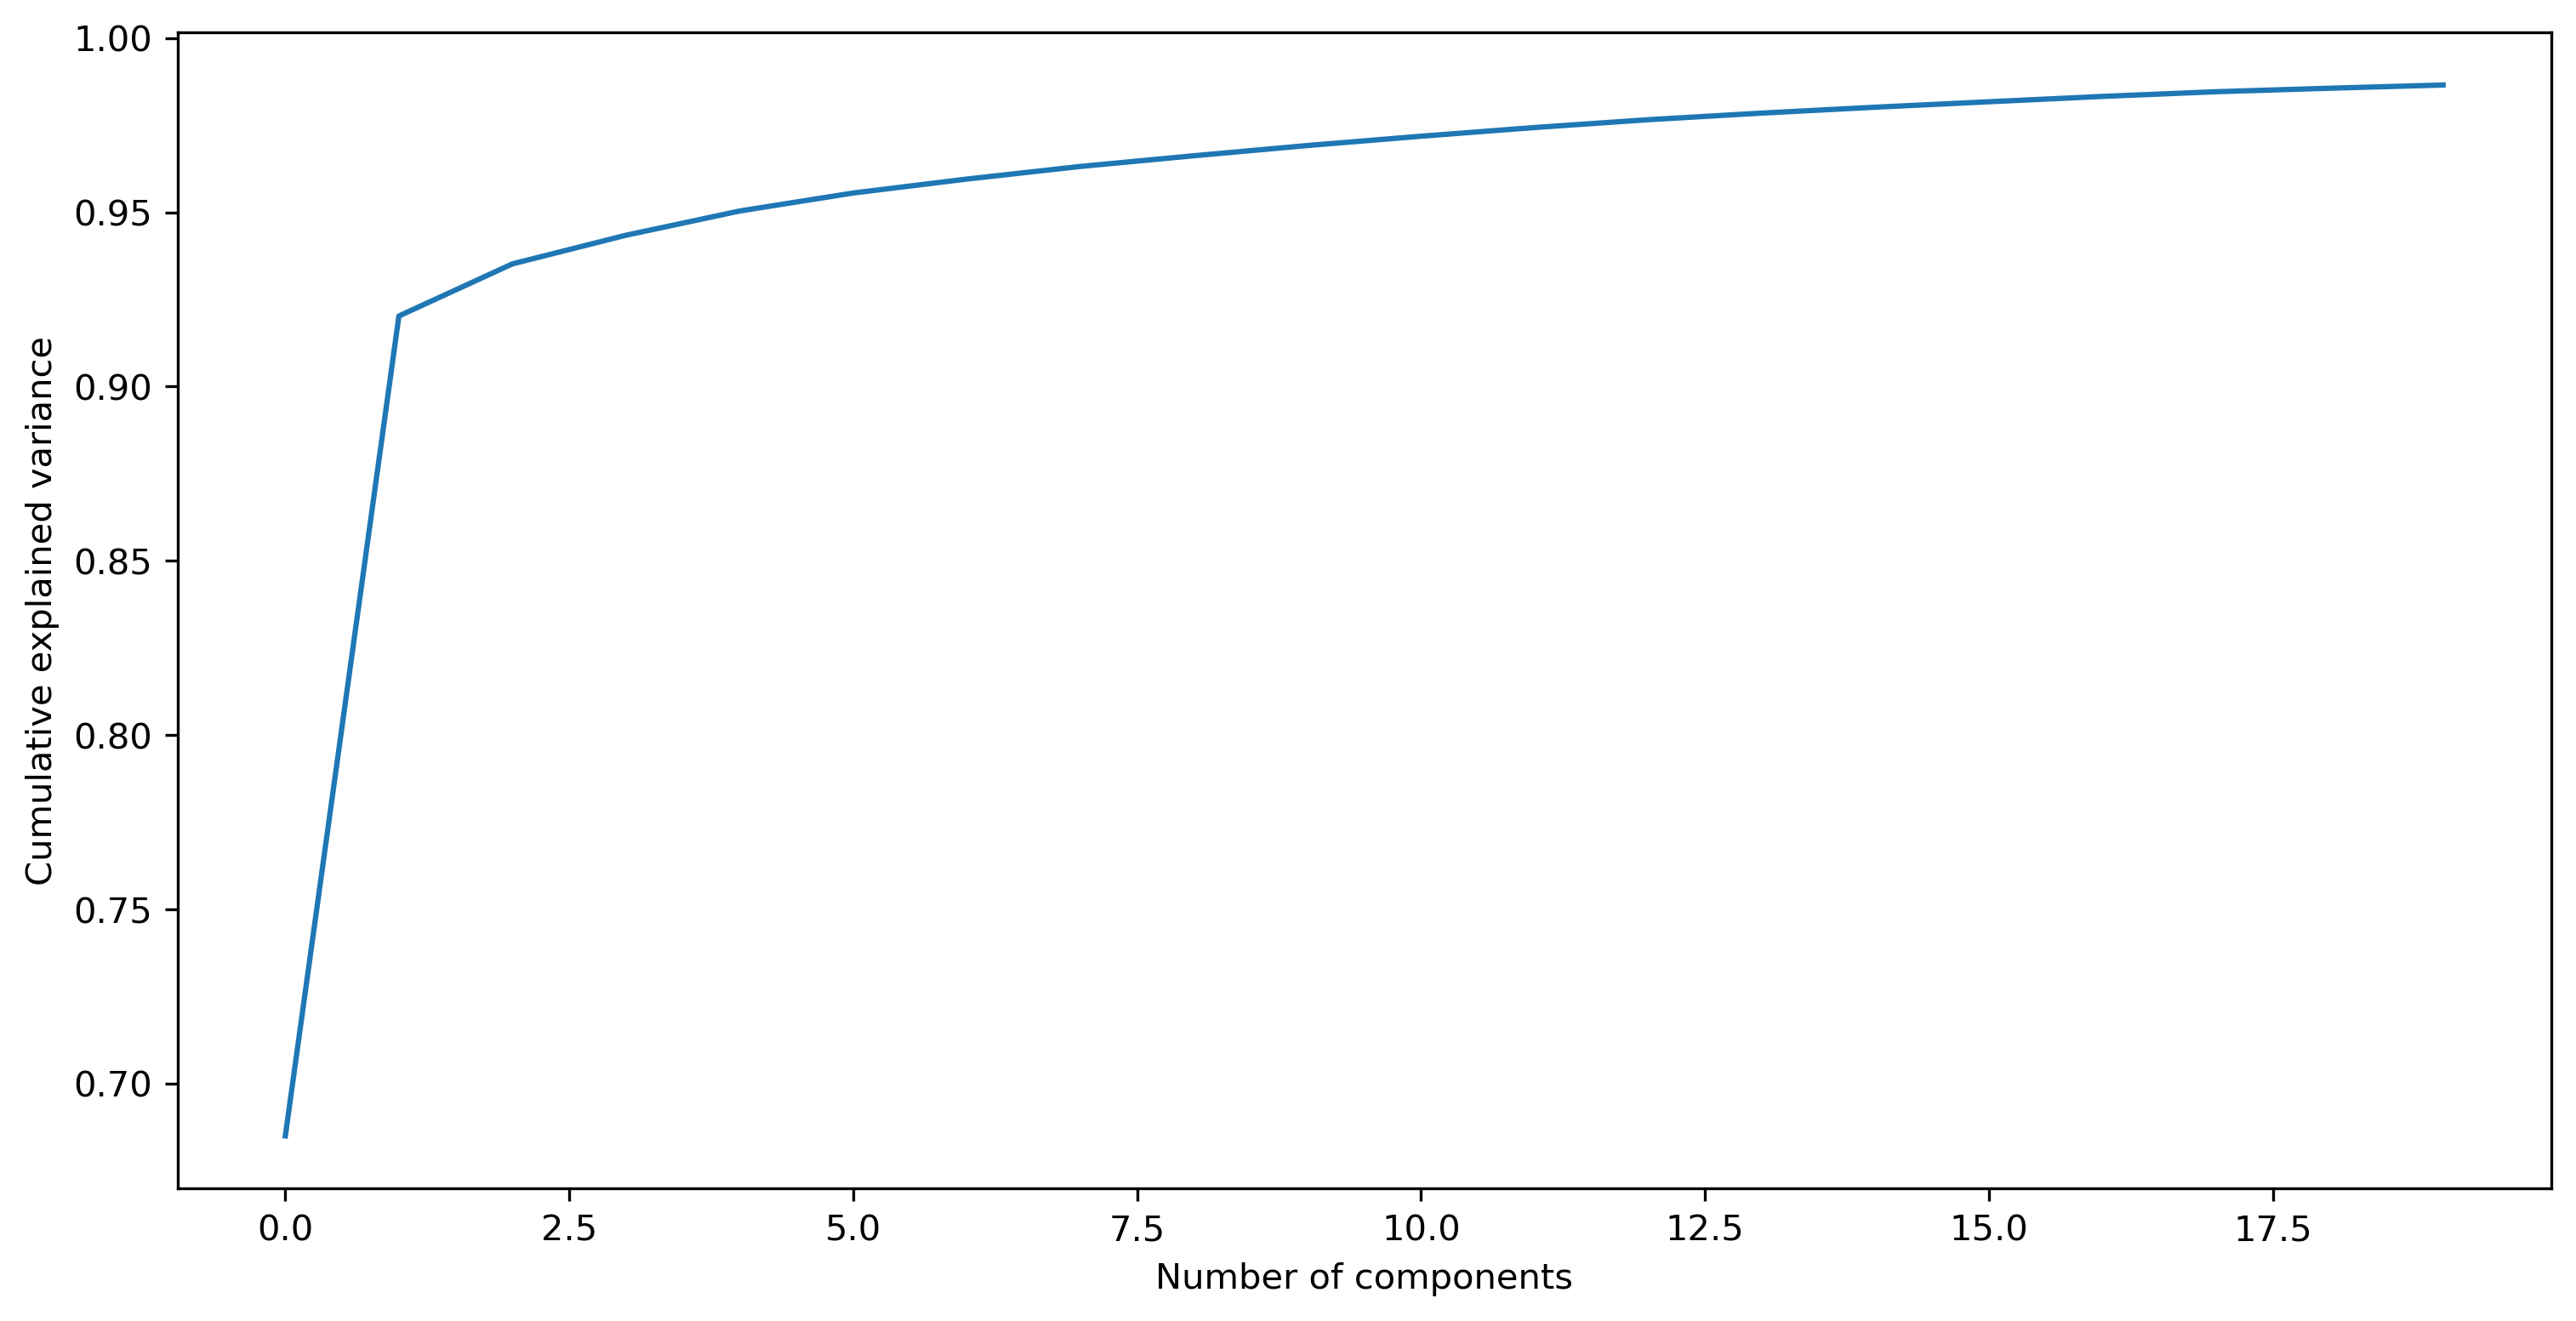

In [166]:
from sklearn.decomposition import PCA

pca_components = 20

pca = PCA(n_components = pca_components)
data = df.iloc[:, :-1].values
df_pca = pca.fit_transform(data)

ev = pca.explained_variance_ratio_

plt.figure(figsize=(12, 6), dpi=300)
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

plt.show()

In [168]:
df_pca.shape

(21025, 20)

## 2.1 递归特征消除（RFE and RFECV）
- API：https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE

`sklearn.feature_selection.RFE(estimator, *, n_features_to_select=None, step=1, verbose=0, importance_getter='auto')`

- 功能：递归消除特征
- estimator：使用的基模型
- n_features_to_select：选择的特征个数
- step：如果大于或等于1，则step对应于在每次迭代中删除的（整数）个特征。如果在（0.0，1.0）之内，则step对应于每次迭代要删除的特征的百分比（四舍五入）。
- Important_getterstr：str or callable, default='auto'，如果为auto，则通过估算器的coef_或feature_importances_属性使用特征重要性。

## ERROR!!!


ValueError: when `importance_getter=='auto'`, the underlying estimator SVC should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

<font color=red size=4>**使用递归特征消除方法时，评估器必须具有`coef_` or `feature_importances_`属性，否则无法使用。可以使用基于树的模型！！！**</font>


### 1. SVC
- API:https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

`sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None)`

- C:正则化参数。正则化的强度与C成反比。必须严格为正。惩罚是平方的l2惩罚。

In [169]:
K_BEST2 = 15

In [219]:
# from sklearn.feature_selection import RFE
# # 导入SVM Classifier
# from sklearn.svm import SVC

# # est = SVC(C=100, kernel='rbf', cache_size=10*1024).fit(df.iloc[:, :-1], df.iloc[:, -1])
# est = SVC(C=100, kernel='rbf', cache_size=10*1024).fit(df_pca, df.iloc[:, -1])

# fs_RFE_SVM = RFE(estimator=est,
#                  n_features_to_select= K_BEST2,
#                  step=1)
# fs_RFE_SVM

### AttributeError: 'RFE' object has no attribute 'support_'

In [220]:
# fs_RFE_SVM.support_

In [221]:
# fs_RFE_SVM.ranking_

### 2. LR
- API：https://scikit-learn.org/0.15/modules/generated/sklearn.linear_model.LogisticRegression.html

`sklearn.linear_model.LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None)`

- penalty : string, ‘l1’ or ‘l2’ 用于指定惩罚中使用的范数。
- dual : boolean 对偶或原始形式。对偶公式化仅适用于12惩罚。当 `n_samples> n_features` 时，首选dual = False。
- C : float, optional (default=1.0) ，正则强度的倒数；必须为正浮点数。像在支持向量机中一样，较小的值指定更强的正则化。

In [187]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

fs_RFE_LR = RFE(estimator=LogisticRegression(), 
                n_features_to_select=15
               ).fit_transform(df_pca, 
                               df.iloc[:, -1])
fs_RFE_LR

D:\anaconda\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

array([[  72.69704814,   71.20476152, -435.68704638, ...,  409.26634395,
        -223.36354022,    8.36060373],
       [ 350.13462673, -528.46458237,  148.08789196, ..., -136.67284647,
         165.89823367,   39.10190082],
       [ 490.53993477, -760.21428572,  259.93367717, ..., -217.46786134,
         105.98797523,  -22.63094933],
       ...,
       [ 398.17024351,   94.13269945, -359.55011523, ...,  224.12898844,
          60.5009701 ,  203.42156141],
       [ 676.8089852 , -196.89442065, -766.92603586, ..., -132.41535817,
         -25.04635781,  144.86178326],
       [ 465.45080926,  102.21374699, -552.87389909, ..., -235.47476362,
         -56.62807256,  135.01349685]])

In [193]:
fs_RFE_LR

array([[  72.69704814,   71.20476152, -435.68704638, ...,  409.26634395,
        -223.36354022,    8.36060373],
       [ 350.13462673, -528.46458237,  148.08789196, ..., -136.67284647,
         165.89823367,   39.10190082],
       [ 490.53993477, -760.21428572,  259.93367717, ..., -217.46786134,
         105.98797523,  -22.63094933],
       ...,
       [ 398.17024351,   94.13269945, -359.55011523, ...,  224.12898844,
          60.5009701 ,  203.42156141],
       [ 676.8089852 , -196.89442065, -766.92603586, ..., -132.41535817,
         -25.04635781,  144.86178326],
       [ 465.45080926,  102.21374699, -552.87389909, ..., -235.47476362,
         -56.62807256,  135.01349685]])

In [194]:
fs_RFE_LR.shape

(21025, 15)

### 3. Random Forest
- API:https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier

`sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)`

- n_estimators：int，默认为100，森林中树的数量。
- criterion: 衡量分割质量的函数。{“gini”, “entropy”}, default=”gini”
- max_depth: int, 树的最大深度。如果为None，则将节点展开，直到所有叶子都是纯净的，或者直到所有叶子都包含少于min_samples_split个样本。
- min_samples_split：int或float，默认= 2。分割内部节点所需的最小样本数：
- min_samples_leaf：int或float，默认= 1。在叶节点处需要的最小样本数。

In [182]:
from sklearn.ensemble import RandomForestClassifier

est = RandomForestClassifier(n_estimators=100, 
                             criterion='gini', 
                             max_depth=None,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             )

fs_RFE_RF = RFE(estimator=est, 
                n_features_to_select= K_BEST2
               ).fit_transform(df_pca, 
                               df.iloc[:, -1])

In [184]:
fs_RFE_RF

array([[ 5014.90598496,  1456.86326035,    72.69704814, ...,
         -148.73239874,   -51.74246978,   409.26634395],
       [ 5601.38374305, -2023.45008662,   350.13462673, ...,
           67.40997188,  -126.70576554,  -136.67284647],
       [ 5796.13544234, -3090.39485163,   490.53993477, ...,
          -46.99178978,  -141.25596292,  -217.46786134],
       ...,
       [-7369.83419812, -1132.38176565,   398.17024351, ...,
          404.12543558,   -17.21378495,   224.12898844],
       [-6497.08723914,   798.24003307,   676.8089852 , ...,
          293.28276878,   377.32694168,  -132.41535817],
       [-6570.46116092,   346.74962211,   465.45080926, ...,
          232.15988674,   374.64057429,  -235.47476362]])

In [185]:
fs_RFE_RF.shape

(21025, 15)

# 3. 嵌入式特征选择方法

## 3.1  基于惩罚项的特征选择法（可以直接用，快！）

- API：https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel

`sklearn.feature_selection.SelectFromModel(estimator, *, threshold=None, prefit=False, norm_order=1, max_features=None, importance_getter='auto')`

- 说明：带L1惩罚项的逻辑回归作为基模型的特征选择，用于根据重要性权重选择特征。
- estimator：基学习器。
- threshold：用于特征选择的阈值。

In [162]:
from sklearn.feature_selection import SelectFromModel

fs_embbed_penalty = SelectFromModel(LogisticRegression(penalty="l2", 
                                                       C= 100)
                                   ).fit_transform(df.iloc[:, :-1], 
                                                   df.iloc[:, -1])
fs_embbed_penalty

D:\anaconda\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[3172, 4142, 4506, ..., 2045, 2003, 1999],
       [2580, 4266, 4502, ..., 2127, 2090, 2072],
       [3687, 4266, 4421, ..., 2172, 2127, 2114],
       ...,
       [3153, 3864, 4282, ..., 1546, 1532, 1523],
       [3155, 4104, 4106, ..., 1513, 1493, 1483],
       [3323, 3860, 4197, ..., 1529, 1509, 1495]], dtype=int64)

In [163]:
fs_embbed_penalty.shape

(21025, 99)

## 3.2 基于树模型的特征选择法 （直接对200维选择太慢，先降维）

- API:https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

`sklearn.ensemble.GradientBoostingClassifier(*, loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)`

In [195]:
# from sklearn.feature_selection import SelectFromModel
# from sklearn.ensemble import GradientBoostingClassifier

# # GBDT
# est = GradientBoostingClassifier(loss='deviance',
#                                  learning_rate=0.1,
#                                  n_estimators=100)

# fs_embbed_gbdt = SelectFromModel(estimator=est)
# fs_embbed_gbdt.fit(df_pca, df.iloc[:, -1])
# fs_embbed_gbdt

SelectFromModel(estimator=GradientBoostingClassifier())

### AttributeError: 'SelectFromModel' object has no attribute 'support_'

In [217]:
# fs_embbed_gbdt.support_

In [216]:
# fs_embbed_gbdt.ranking_

## 4. 可解释性特征选择方法：Boruta

In [200]:
from boruta import BorutaPy
from sklearn.inspection import permutation_importance

In [202]:
# perm_importance = permutation_importance(xgb_model, train_x, train_y)

In [201]:
# 均为默认参数
# n_jobs= 4, # 要并行运行的任务数：fit，predict，decision_path和apply在树上并行化。
rf_model = RandomForestClassifier(
                  max_features= 'auto',
                  max_depth= None,
                  min_samples_split= 2,
                  min_samples_leaf= 1,
                  n_estimators= 'auto',
                  bootstrap= True)

In [210]:
feature_selector = BorutaPy(rf_model,
                            n_estimators= 10,
                            max_iter= 50,
                            verbose= 0)

feature_selector.fit(df_pca, df.iloc[:, -1])

BorutaPy(estimator=RandomForestClassifier(n_estimators=10,
                                          random_state=RandomState(MT19937) at 0x1E505381340),
         max_iter=50, n_estimators=10,
         random_state=RandomState(MT19937) at 0x1E505381340)

In [212]:
# check selected features - first 5 features are selected
feature_selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [213]:
# check ranking of features
feature_selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [214]:
# call transform() on X to filter it down to selected features
X_filtered = feature_selector.transform(df_pca)
X_filtered.shape

(21025, 20)

In [225]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def svm_matrix_plot(X, y):
    """
    使用SVM对数据进行分类，绘制结果，并统计分类精度、召回率和F1分数
    ----
    param X:数据样本集（不含标签），np.array
    param y:数据集标签，np.array
    """
    # 训练集测试集划分，比例8:2
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11, stratify=y)
    # 实例化分类器，核函数：径向基函数（高斯核）
    svm = SVC(C=100, kernel='rbf', cache_size=10*1024)
    # 训练分类器
    svm.fit(X_train, y_train)
    # 测试集的预测结果
    ypred = svm.predict(X_test)
    
    # 分类结果的混淆矩阵
    conf_matrix = confusion_matrix(y_test, ypred)
    df_cm = pd.DataFrame(conf_matrix, columns=np.unique(names), index = np.unique(names))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    
    plt.figure(figsize = (10,8))
    sns.set(font_scale = 1.4)#for label size
    sns.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
    
    print(classification_report(y_test, ypred, target_names = names))
    
    return svm

In [252]:
def plot_classify(svm, q, save_name='IP_cmap'):
    """
    绘制分类结果
    ----
    param svm：训练好的svm分类器
    param q：数据集，DataFrame
    """
    l=[]
    
    for i in range(q.shape[0]):
        if q.iloc[i, -1] == 0:
            l.append(0)
        else:
            l.append(svm.predict(q.iloc[i, :-1].values.reshape(1, -1)))

    clmap = np.array(l).reshape(145, 145).astype('float')
    plt.figure(figsize=(10, 8))
    plt.imshow(clmap, cmap='nipy_spectral')
    plt.colorbar()
    plt.axis('off')
    plt.savefig(f'./results/{save_name}.png')
    plt.show()

                              precision    recall  f1-score   support

                     Alfalfa       0.89      0.89      0.89         9
                 Corn-notill       0.81      0.73      0.76       286
                Corn-mintill       0.89      0.76      0.82       166
                        Corn       0.73      0.74      0.74        47
               Grass-pasture       0.93      0.95      0.94        97
                 Grass-trees       0.95      0.97      0.96       146
         Grass-pasture-mowed       1.00      0.80      0.89         5
               Hay-windrowed       0.99      1.00      0.99        96
                        Oats       0.33      0.50      0.40         4
              Soybean-notill       0.82      0.77      0.79       194
             Soybean-mintill       0.81      0.89      0.84       491
               Soybean-clean       0.82      0.89      0.85       119
                       Wheat       0.95      0.98      0.96        41
                   

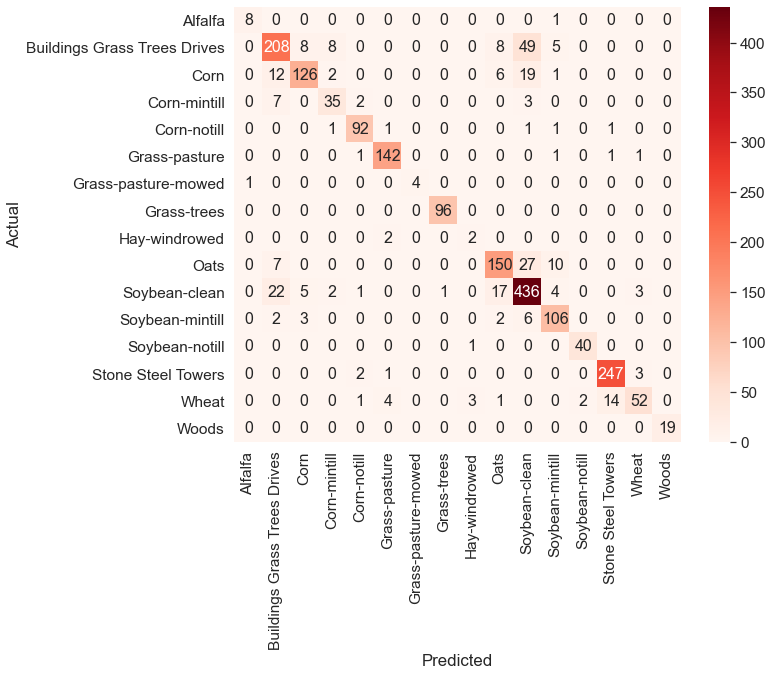

In [238]:
# 去除掉背景（0类）
X = X_filtered
X = X[df['class'] != 0]
y = df[df['class'] != 0].loc[:, 'class'].values

svm = svm_matrix_plot(X, y)

In [239]:
X.shape

(10249, 20)

In [250]:
# 添加真实标签列
X_final = pd.concat([pd.DataFrame(data= X_filtered), pd.DataFrame(df.iloc[:, -1])], axis = 1)

<ipython-input-223-c845a6e4195e>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  clmap = np.array(l).reshape(145, 145).astype('float')


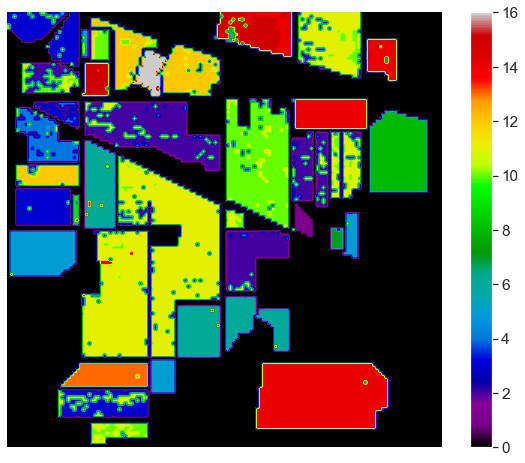

In [251]:
plot_classify(svm, X_final, save_name = 'FS_Boruta')